In [2]:
################################################################################################################################
#
# LSTM - JANSEN - FRACDIFF - MINMAX - MONTHLY
#
################################################################################################################################

#-------------------------------------------------------------------------------------------------------------------------------
# Test RMSE: 
#-------------------------------------------------------------------------------------------------------------------------------

#===============================================================================================================================
# ENVIRONMENT: LIBRARIES, SETTINGS
#===============================================================================================================================
#pip install pandas-datareader

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd
import pandas_datareader.data as web
import sklearn
import sklearn.preprocessing
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import spearmanr

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Activation
from tensorflow import keras

In [3]:
#===============================================================================================================================
# ENVIRONMENT: HARDWARE
#===============================================================================================================================
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using CPU


In [4]:
#===============================================================================================================================
# ENVIRONMENT: CONFIG
#===============================================================================================================================
sns.set_style('whitegrid')
np.random.seed(42)

In [5]:
#===============================================================================================================================
# DATA: PATHS - INPUT/OUTPUT
#===============================================================================================================================
input_path = Path('Data', 'Input')
results_path = Path('Data\Output', 'Jansen-LSTM-FracDiff-MinMax-Monthly')
if not results_path.exists():
    results_path.mkdir(parents=True)

In [6]:
#===============================================================================================================================
# DATA: SETTINGS
#===============================================================================================================================
seriesId='IBOV-FracDiff-Prc-Monthly'
#ESCALA = 'log'  #'minmax' 
#EPOCAS = 100
#LOTE = 12
#NEURONS = 32
window_size=6

In [9]:
#===============================================================================================================================
# DATA: READ - FFD
#===============================================================================================================================
df = pd.read_csv('Data/Input/'+seriesId+'.csv')
#df['Date']= pd.to_datetime(df['Date'], format='%d/%m/%Y')
df.set_index('Date', inplace=True)
df

,Close
Date,
2004-07-30,5368.052427
2004-08-31,5161.160284
2004-09-30,5154.415176
2004-10-29,4563.160784
2004-11-30,6511.315022
...,...
2023-08-31,15408.101301
2023-09-29,17566.001656
2023-10-31,13856.481278


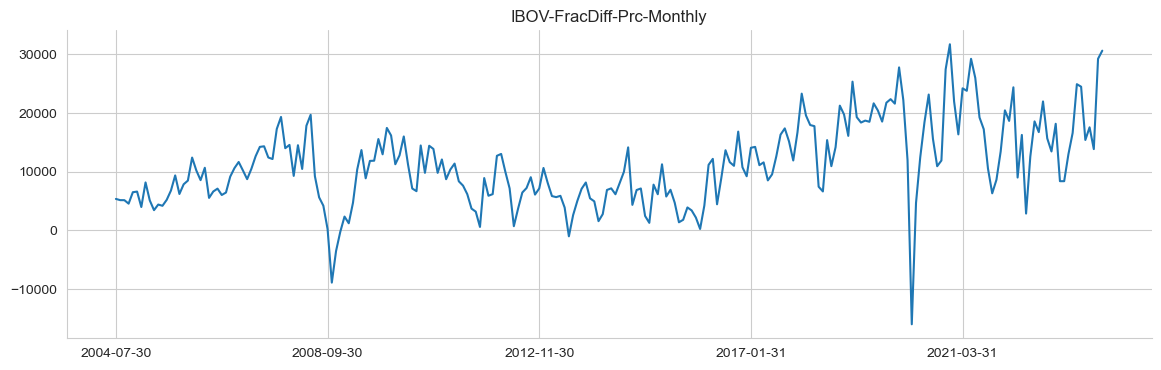

In [10]:
#===============================================================================================================================
# DATA: PLOT - FFD
#===============================================================================================================================
ax = df.plot(title=seriesId, legend=False, figsize=(14, 4), rot=0)
ax.set_xlabel('')
sns.despine()

In [11]:
#===============================================================================================================================
# DATA: SCALE - TRAIN
#===============================================================================================================================
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_scaled = pd.Series(scaler.fit_transform(df[:'2023']).squeeze(), index=df[:'2023'].index)
df_scaled

Date
2004-07-30    0.447699
2004-08-31    0.443361
2004-09-30    0.443220
2004-10-29    0.430823
2004-11-30    0.471670
                ...   
2022-08-31    0.724617
2022-09-30    0.686308
2022-10-31    0.795846
2022-11-30    0.663970
2022-12-29    0.617193
Length: 222, dtype: float64

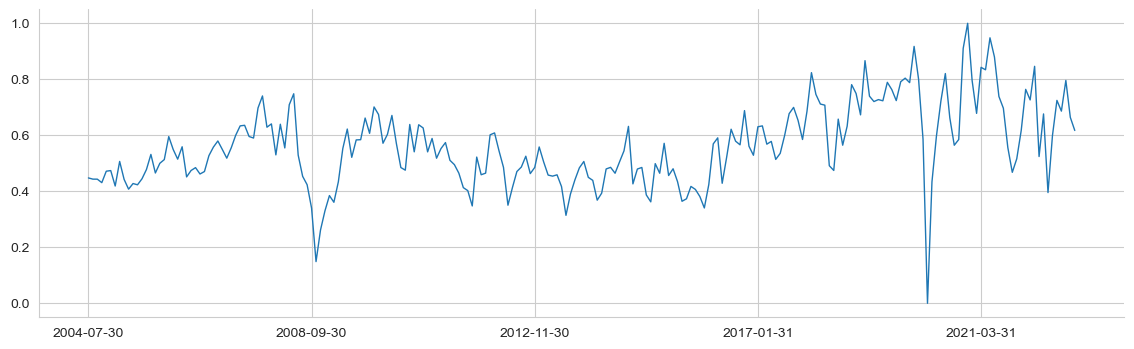

In [12]:
#===============================================================================================================================
# DATA: SCALE - PLOT - TRAIN
#===============================================================================================================================
ax = df_scaled.plot(lw=1, figsize=(14, 4), rot=0)
ax.set_xlabel('')
sns.despine()

In [13]:
#===============================================================================================================================
# DATA: PREP - RECURRENT SEQUENCES - FUNCTION
#===============================================================================================================================
def create_univariate_rnn_data(data, window_size):
    n = len(data)
    y = data[window_size:]
    #y = data[window_size-1:]
    data = data.values.reshape(-1, 1) # make 2D
    X = np.hstack(tuple([data[i: n-j, :] for i, j in enumerate(range(window_size, 0, -1))]))
    #X = np.hstack(tuple([data[i: n-j+1, :] for i, j in enumerate(range(window_size, 0, -1))]))
    return pd.DataFrame(X, index=y.index), y

In [14]:
#===============================================================================================================================
# DATA: PREP - SEQUENCES - TRAIN
#===============================================================================================================================
X, y = create_univariate_rnn_data(df_scaled, window_size=window_size)
X

,0,1,2,3,4,5
Date,,,,,,
2005-01-31,0.447699,0.443361,0.443220,0.430823,0.471670,0.473913
2005-02-28,0.443361,0.443220,0.430823,0.471670,0.473913,0.418828
2005-03-31,0.443220,0.430823,0.471670,0.473913,0.418828,0.506600
2005-04-29,0.430823,0.471670,0.473913,0.418828,0.506600,0.442383
2005-05-31,0.471670,0.473913,0.418828,0.506600,0.442383,0.407580
...,...,...,...,...,...,...
2022-08-31,0.726295,0.846251,0.524100,0.676225,0.395389,0.598980
2022-09-30,0.846251,0.524100,0.676225,0.395389,0.598980,0.724617
2022-10-31,0.524100,0.676225,0.395389,0.598980,0.724617,0.686308


In [15]:
y

Date
2005-01-31    0.418828
2005-02-28    0.506600
2005-03-31    0.442383
2005-04-29    0.407580
2005-05-31    0.427614
                ...   
2022-08-31    0.724617
2022-09-30    0.686308
2022-10-31    0.795846
2022-11-30    0.663970
2022-12-29    0.617193
Length: 216, dtype: float64

In [16]:
#===============================================================================================================================
# DATA PREP: SPLIT
#===============================================================================================================================
X_train = X[:'2023'].values.reshape(-1, window_size, 1)
y_train = y[:'2023']
y_train

Date
2005-01-31    0.418828
2005-02-28    0.506600
2005-03-31    0.442383
2005-04-29    0.407580
2005-05-31    0.427614
                ...   
2022-08-31    0.724617
2022-09-30    0.686308
2022-10-31    0.795846
2022-11-30    0.663970
2022-12-29    0.617193
Length: 216, dtype: float64

In [17]:
#===============================================================================================================================
# DATA: SCALE - TEST
#===============================================================================================================================
df_scaledtest = pd.Series(scaler.transform(df['2022-07':]).squeeze(), index=df['2022-07':].index)
print(df_scaledtest.describe())
df_scaledtest

count    18.000000
mean      0.707450
std       0.132937
min       0.511026
25%       0.619313
50%       0.684834
75%       0.778039
max       0.977151
dtype: float64


Date
2022-07-29    0.598980
2022-08-31    0.724617
2022-09-30    0.686308
2022-10-31    0.795846
2022-11-30    0.663970
2022-12-29    0.617193
2023-01-31    0.716051
2023-02-28    0.511054
2023-03-31    0.511026
2023-04-28    0.607122
2023-05-31    0.683360
2023-06-30    0.857453
2023-07-31    0.848478
2023-08-31    0.658208
2023-09-29    0.703452
2023-10-31    0.625675
2023-11-30    0.948155
2023-12-28    0.977151
dtype: float64

In [18]:
#===============================================================================================================================
# DATA: PREP - SEQUENCES - TEST
#===============================================================================================================================
Xtest, ytest = create_univariate_rnn_data(df_scaledtest, window_size=window_size)
Xtest

,0,1,2,3,4,5
Date,,,,,,
2023-01-31,0.598980,0.724617,0.686308,0.795846,0.663970,0.617193
2023-02-28,0.724617,0.686308,0.795846,0.663970,0.617193,0.716051
2023-03-31,0.686308,0.795846,0.663970,0.617193,0.716051,0.511054
2023-04-28,0.795846,0.663970,0.617193,0.716051,0.511054,0.511026
2023-05-31,0.663970,0.617193,0.716051,0.511054,0.511026,0.607122
2023-06-30,0.617193,0.716051,0.511054,0.511026,0.607122,0.683360
2023-07-31,0.716051,0.511054,0.511026,0.607122,0.683360,0.857453
2023-08-31,0.511054,0.511026,0.607122,0.683360,0.857453,0.848478
2023-09-29,0.511026,0.607122,0.683360,0.857453,0.848478,0.658208


In [19]:
#===============================================================================================================================
# DATA PREP: RECURRENT SEQUENCES - TEST
#===============================================================================================================================
X_test = Xtest['2023':].values.reshape(-1, window_size, 1)
y_test = ytest['2023':]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(216, 6, 1) (216,) (12, 6, 1) (12,)


In [20]:
#===============================================================================================================================
# DATA PREP: OBS, WINDOWS, FEATURES
#===============================================================================================================================
n_obs, window_size, n_features = X_train.shape
n_obs, window_size, n_features

(216, 6, 1)

In [21]:
#===============================================================================================================================
# MODEL: LSTM
#===============================================================================================================================
rnn = Sequential([
    LSTM(units=10, input_shape=(window_size, n_features), name='LSTM'),
    Dense(1, name='Output')
])

rnn.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM (LSTM)                 (None, 10)                480       
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 491 (1.92 KB)
Trainable params: 491 (1.92 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
#===============================================================================================================================
# MODEL: CONFIG
#===============================================================================================================================
optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, weight_decay=0.0)

rnn.compile(loss='mean_squared_error', optimizer=optimizer)

rnn_path = (results_path / 'Jansen-FracDiff-MinMax-Monthly-rnn.h5').as_posix()
checkpointer = ModelCheckpoint(filepath=rnn_path, verbose=1, monitor='val_loss', save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

In [23]:
#===============================================================================================================================
# MODEL: TRAIN
#===============================================================================================================================
lstm_training = rnn.fit(X_train, y_train, epochs=150, batch_size=12, shuffle=True, 
                        validation_data=(X_test, y_test), 
                        callbacks=[early_stopping, checkpointer],verbose=1)

Epoch 1/150

15/18 [========================>.....] - ETA: 0s - loss: 0.3083 
Epoch 1: val_loss improved from inf to 0.34580, saving model to Data/Output/Jansen-LSTM-FracDiff-MinMax-Monthly\Jansen-FracDiff-MinMax-Monthly-rnn.h5
18/18 [==============================] - 3s 39ms/step - loss: 0.2860 - val_loss: 0.3458
Epoch 2/150
14/18 [======================>.......] - ETA: 0s - loss: 0.1527
Epoch 2: val_loss improved from 0.34580 to 0.17461, saving model to Data/Output/Jansen-LSTM-FracDiff-MinMax-Monthly\Jansen-FracDiff-MinMax-Monthly-rnn.h5
18/18 [==============================] - 0s 7ms/step - loss: 0.1371 - val_loss: 0.1746
Epoch 3/150
14/18 [======================>.......] - ETA: 0s - loss: 0.0546
Epoch 3: val_loss improved from 0.17461 to 0.06672, saving model to Data/Output/Jansen-LSTM-FracDiff-MinMax-Monthly\Jansen-FracDiff-MinMax-Monthly-rnn.h5
18/18 [==============================] - 0s 8ms/step - loss: 0.0503 - val_loss: 0.0667
Epoch 4/150
15/18 [========================>.....]

14/18 [======================>.......] - ETA: 0s - loss: 0.0133
Epoch 34: val_loss did not improve from 0.02390
18/18 [==============================] - 0s 7ms/step - loss: 0.0127 - val_loss: 0.0256
Epoch 35/150
13/18 [====================>.........] - ETA: 0s - loss: 0.0134
Epoch 35: val_loss did not improve from 0.02390
18/18 [==============================] - 0s 7ms/step - loss: 0.0127 - val_loss: 0.0258
Epoch 36/150
11/18 [=================>............] - ETA: 0s - loss: 0.0137
Epoch 36: val_loss did not improve from 0.02390
18/18 [==============================] - 0s 6ms/step - loss: 0.0126 - val_loss: 0.0265
Epoch 37/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0206
Epoch 37: val_loss did not improve from 0.02390
18/18 [==============================] - 0s 5ms/step - loss: 0.0126 - val_loss: 0.0260
Epoch 38/150
13/18 [====================>.........] - ETA: 0s - loss: 0.0127
Epoch 38: val_loss did not improve from 0.02390
18/18 [==============================] -

Epoch 71/150
16/18 [=========================>....] - ETA: 0s - loss: 0.0114
Epoch 71: val_loss did not improve from 0.02002
18/18 [==============================] - 0s 7ms/step - loss: 0.0110 - val_loss: 0.0241
Epoch 72/150
13/18 [====================>.........] - ETA: 0s - loss: 0.0110
Epoch 72: val_loss did not improve from 0.02002
18/18 [==============================] - 0s 9ms/step - loss: 0.0110 - val_loss: 0.0229
Epoch 73/150
14/18 [======================>.......] - ETA: 0s - loss: 0.0113
Epoch 73: val_loss did not improve from 0.02002
18/18 [==============================] - 0s 8ms/step - loss: 0.0110 - val_loss: 0.0237
Epoch 74/150
12/18 [===================>..........] - ETA: 0s - loss: 0.0089
Epoch 74: val_loss did not improve from 0.02002
18/18 [==============================] - 0s 8ms/step - loss: 0.0109 - val_loss: 0.0267
Epoch 75/150
12/18 [===================>..........] - ETA: 0s - loss: 0.0127
Epoch 75: val_loss did not improve from 0.02002
18/18 [====================

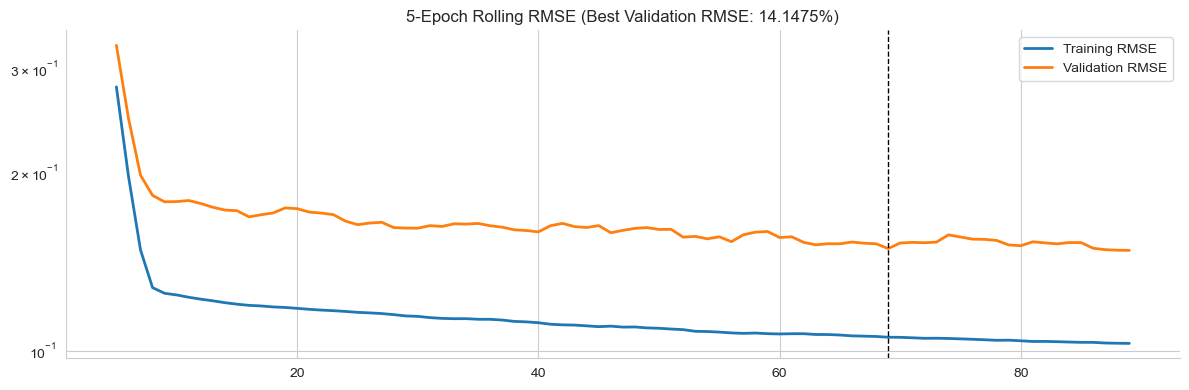

In [24]:
#===============================================================================================================================
# RESULTS: PERFORMANCE vs EPOCHS - TRAIN, VALIDATION
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(12, 4))

loss_history = pd.DataFrame(lstm_training.history).pow(.5)
loss_history.index += 1
best_rmse = loss_history.val_loss.min()

best_epoch = loss_history.val_loss.idxmin()

title = f'5-Epoch Rolling RMSE (Best Validation RMSE: {best_rmse:.4%})'
loss_history.columns=['Training RMSE', 'Validation RMSE']
loss_history.rolling(5).mean().plot(logy=True, lw=2, title=title, ax=ax)

ax.axvline(best_epoch, ls='--', lw=1, c='k')

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_error', dpi=300);

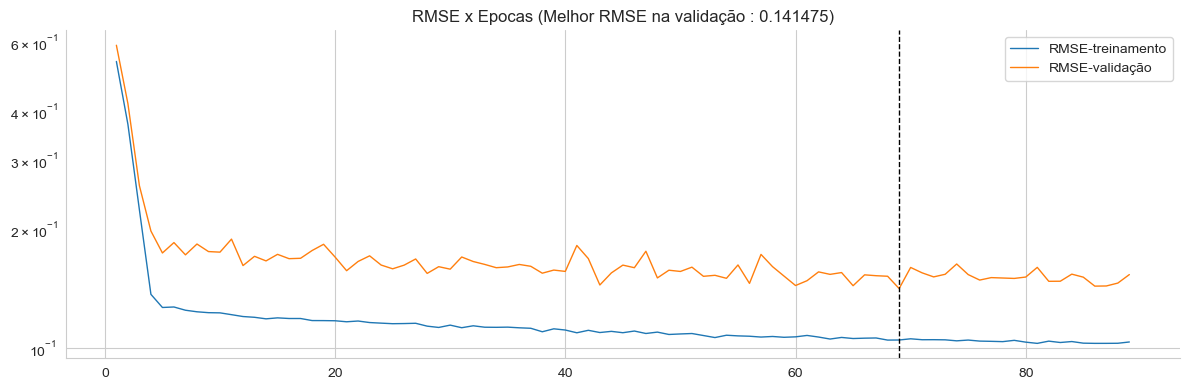

In [25]:
#===============================================================================================================================
# RESULTS - PERFORMANCE vs EPOCHS - TRAIN, VALIDATION
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(12, 4))

loss_history = pd.DataFrame(lstm_training.history).pow(.5)
loss_history.index += 1
best_rmse = loss_history.val_loss.min()

best_epoch = loss_history.val_loss.idxmin()

title = f'RMSE x Epocas (Melhor RMSE na validação : {best_rmse:.6})'
loss_history.columns=['RMSE-treinamento', 'RMSE-validação']
loss_history.rolling(1).mean().plot(logy=True, lw=1, title=title, ax=ax)

ax.axvline(best_epoch, ls='--', lw=1, c='k')

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_error', dpi=300);

In [26]:
#===============================================================================================================================
# RESULTS: PERFORMANCE - TRAIN, TEST
#===============================================================================================================================
train_rmse_scaled = np.sqrt(rnn.evaluate(X_train, y_train, verbose=0))
test_rmse_scaled = np.sqrt(rnn.evaluate(X_test, y_test, verbose=0))
print(f'Train RMSE: {train_rmse_scaled:.4f} | Test RMSE: {test_rmse_scaled:.4f}')
#-------------------------------------------------------------------------------------------------------------------------------
# Train RMSE: 0.1087 | Test RMSE: 0.1464
#-------------------------------------------------------------------------------------------------------------------------------

Train RMSE: 0.1072 | Test RMSE: 0.1415


In [27]:
#===============================================================================================================================
# RESULTS: FORECAST - TRAIN, TEST
#===============================================================================================================================
train_predict_scaled = rnn.predict(X_train)
test_predict_scaled = rnn.predict(X_test)

1/1 [==============================] - 0s 28ms/step


In [28]:
#===============================================================================================================================
# RESULTS - SPEARMAN IC - TRAIN, TEST
#===============================================================================================================================
train_ic = spearmanr(y_train, train_predict_scaled)[0]
test_ic = spearmanr(y_test, test_predict_scaled)[0]
print(f'Train IC: {train_ic:.6f} | Test IC: {test_ic:.5f}')
#-------------------------------------------------------------------------------------------------------------------------------
# Train IC: 0.662408 | Test IC: 0.20280
#-------------------------------------------------------------------------------------------------------------------------------

Train IC: 0.732497 | Test IC: 0.32867


In [29]:
#===============================================================================================================================
# RESULTS - FORECAST - RESULTS
#===============================================================================================================================
np.savetxt('Data/Output/LSTM-Jansen-FracDiff-MinMax-Monthly-Train.txt', train_predict_scaled, delimiter=';')
np.savetxt('Data/Output/LSTM-Jansen-FracDiff-MinMax-Monthly-Test.txt' , test_predict_scaled , delimiter=';')
test_predict_scaled[:,0]

array([0.6725393 , 0.6970132 , 0.62629807, 0.60154444, 0.61345667,
       0.6409955 , 0.71685255, 0.75042397, 0.7109408 , 0.7203285 ,
       0.68749076, 0.78778887], dtype=float32)

In [30]:
#===============================================================================================================================
# RESULTS - FRACDIFF - RECOVER - PRED - TRAIN, TEST
#===============================================================================================================================
train_predict = pd.Series(scaler.inverse_transform(train_predict_scaled).squeeze(), index=y_train.index)
test_predict  = pd.Series(scaler.inverse_transform(test_predict_scaled).squeeze() , index=y_test.index)

test_predict

Date
2023-01-31    16091.628906
2023-02-28    17258.892578
2023-03-31    13886.191406
2023-04-28    12705.586914
2023-05-31    13273.730469
2023-06-30    14587.172852
2023-07-31    18205.113281
2023-08-31    19806.275391
2023-09-29    17923.156250
2023-10-31    18370.896484
2023-11-30    16804.726562
2023-12-28    21588.363281
dtype: float32

In [31]:
#===============================================================================================================================
# RESULTS - FRACDIFF - RECOVER - TARGET - TRAIN, TEST
#===============================================================================================================================
y_train_rescaled = scaler.inverse_transform(y_train.to_frame()).squeeze()
y_test_rescaled = scaler.inverse_transform(y_test.to_frame()).squeeze()

y_test_rescaled

array([18166.89173422,  8389.69761743,  8388.3809416 , 12971.59905482,
       16607.6990424 , 24910.92375634, 24482.86307971, 15408.10130136,
       17566.0016559 , 13856.48127845, 29236.8989415 , 30619.83794848])

In [32]:
#===============================================================================================================================
# RESULTS - FRACDIFF - PERFORMANCE - TRAIN, TEST
#===============================================================================================================================
train_rmse = np.sqrt(mean_squared_error(train_predict, y_train_rescaled))
test_rmse = np.sqrt(mean_squared_error(test_predict, y_test_rescaled))
f'Train RMSE: {train_rmse:.2f} | Test RMSE: {test_rmse:.2f}'
#-------------------------------------------------------------------------------------------------------------------------------
# 'Train RMSE: 5509.61 | Test RMSE: 7198.34'
#-------------------------------------------------------------------------------------------------------------------------------

'Train RMSE: 5111.09 | Test RMSE: 6747.53'

In [33]:
#===============================================================================================================================
# RESULTS - FRACDIFF - STORE - TRAIN, TEST
#===============================================================================================================================
df['Train Predictions'] = train_predict
df['Test Predictions'] = test_predict

temp = pd.concat([train_predict.to_frame('predictions').assign(data='Train'), test_predict.to_frame('predictions').assign(data='Test')])
df['predictions'] = temp['predictions']
df['data']        = temp[ 'data']

df['2022-12-29':]

,Close,Train Predictions,Test Predictions,predictions,data
Date,,,,,
2022-12-29,13451.929948,16748.839844,NaN,16748.839844,Train
2023-01-31,18166.891734,NaN,16091.628906,16091.628906,Test
2023-02-28,8389.697617,NaN,17258.892578,17258.892578,Test
2023-03-31,8388.380942,NaN,13886.191406,13886.191406,Test
2023-04-28,12971.599055,NaN,12705.586914,12705.586914,Test
2023-05-31,16607.699042,NaN,13273.730469,13273.730469,Test
2023-06-30,24910.923756,NaN,14587.172852,14587.172852,Test
2023-07-31,24482.863080,NaN,18205.113281,18205.113281,Test
2023-08-31,15408.101301,NaN,19806.275391,19806.275391,Test


In [34]:
#===============================================================================================================================
# RESULTS - FRACDIFF - EXPORT
#===============================================================================================================================
df.to_excel('Data/Output/LSTM-Jansen-FracDiff-MinMax-Monthly.xlsx')

KeyError: 'Residuals'

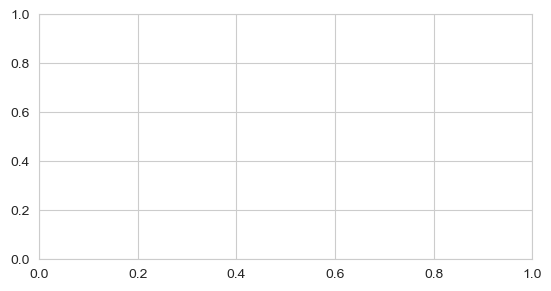

In [35]:
#===============================================================================================================================
# RESULTS - FRACDIFF - PLOT
#===============================================================================================================================
fig=plt.figure(figsize=(14,7))

ax1 = plt.subplot(221)
df.loc['2000':, 'Residuals'].plot(lw=2, ax=ax1, c='k')
df.loc['2000':, 'predictions'].plot(lw=1.5, ax=ax1, c='k')
df.loc['2000':, ['Test Predictions', 'Train Predictions']].plot(lw=1, ax=ax1, ls='--')
ax1.set_title('In- and Out-of-sample Predictions')

with sns.axes_style("white"):
    ax3 = plt.subplot(223)
    sns.scatterplot(x='Residuals', y='predictions', data=df, hue='data', ax=ax3)
    ax3.text(x=.02, y=.95, s=f'Test IC ={test_ic:.2%}', transform=ax3.transAxes)
    ax3.text(x=.02, y=.87, s=f'Train IC={train_ic:.2%}', transform=ax3.transAxes)
    ax3.set_title('Correlation')
    ax3.legend(loc='lower right')
    
    ax2 = plt.subplot(222)
    ax4 = plt.subplot(224, sharex = ax2, sharey=ax2)
    sns.distplot(train_predict.squeeze()- y_train_rescaled, ax=ax2)
    ax2.set_title('Train Error')
    ax2.text(x=.03, y=.92, s=f'Train RMSE ={train_rmse:.4f}', transform=ax2.transAxes)
    sns.distplot(test_predict.squeeze()-y_test_rescaled, ax=ax4)
    ax4.set_title('Test Error')
    ax4.text(x=.03, y=.92, s=f'Test RMSE ={test_rmse:.4f}', transform=ax4.transAxes)

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_regression', dpi=300);


In [ ]:
#===============================================================================================================================
# FRACDIFF: RECOVER - PRICES - d, THRESHOLD
#===============================================================================================================================
d=0.2485
THRESHOLD=1e-3

In [ ]:
#===============================================================================================================================
# FRACDIFF: RECOVER - FUNCTION WEIGHTS
#===============================================================================================================================
def getWeights_FFD(d, thres=THRESHOLD, lim=10000):
    w, k = [1.], 1                          # Set w as a list and k as one
    ctr = 0                                 # Set ctr
    while True:                             # Loop While
        w_ = -w[-1] / k * (d - k + 1)          # Create the new weight value
        if abs(w_) < thres:break               # End the loop in case the threshold is breached
        w.append(w_)                           # Append the new value of w
        k += 1                                 # Increment k
        ctr += 1                               # Increment ctr
        if ctr == lim - 1:break                # End the loop in case it breaches the limit
    return np.array(w[::-1]).reshape(-1, 1) # Convert the w from list to a numpy array

In [ ]:
#===============================================================================================================================
# FRACDIFF: RECOVER - WEIGHTS
#===============================================================================================================================
w_FFD = getWeights_FFD(d, thres=1e-3, lim=227)
print(len(w_FFD[:-1]))
w_FFD[:]

In [ ]:
df[-13:]

In [ ]:
#===============================================================================================================================
# PREDICTION FFD: y_pred_fracdiff
#===============================================================================================================================
#y_pred_fracdiff=df.loc['2023-01-31':,'predictions'].to_frame()
y_pred_fracdiff=df['predictions'].to_frame()
y_pred_fracdiff.rename(columns={'predictions':'Residuals'}, inplace=True)
y_pred_fracdiff[-13:]


In [ ]:
#===============================================================================================================================
# DATA: READ - PRICES - ORI
#===============================================================================================================================
seriesId = 'IBOV-monthly'
df_temp = pd.read_csv(seriesId+'.csv')

df_test_ori = df_temp.copy()
df_test_ori['Date'] = pd.to_datetime(df_test_ori['Date'], dayfirst=True)
df_test_ori = df_test_ori.loc[:, ['Date', 'Close']]
df_test_ori = df_test_ori.set_index('Date')
df_test_ori = df_test_ori['2023':]
df_test_ori

In [ ]:
#===============================================================================================================================
# DATA: RECOVER - FRACDIFF - FUNCTION
#===============================================================================================================================
def fracDiff_FFD_recover(series_ffd,d,thres=THRESHOLD, w=None,series_ori=None):

    width=len(w)
    
    df= {}
    prices_ori,df_=series_ori, pd.Series() 
    
    print('width = ',width)
    print('')
    #---------------------------------------------------------------------------------------------------------------------------
    # Loop W
    #---------------------------------------------------------------------------------------------------------------------------
    for iloc1 in range(0,width):
        print('-------------------------------------------------')
        #-----------------------------------------------------------------------------------------------------------------------
        # loc0, loc1
        #-----------------------------------------------------------------------------------------------------------------------
        loc0=prices_ori.index[iloc1]
        loc1=prices_ori.index[iloc1-width-1]
        locffd0=series_ffd.index[iloc1]

        print('')
        print('Loop: iloc1=', iloc1, ' | loc0=', loc0, ' | loc1=', loc1, ' | locffd0=', locffd0)

        if not (np.isfinite(series_ori.loc[loc1])).any():continue

        print('')
        print('w[iloc1]           = ', np.round(w[iloc1],6))
        print('series_ori[loc0]   = ', series_ori.loc[loc0,'Close'])
        print('series_ori[loc1]   = ', series_ori.loc[loc1,'Close'])
        print('series_ffd[locffd0]= ', series_ffd.loc[locffd0,'Residuals'])
            
        #-----------------------------------------------------------------------------------------------------------------------
        # Dot Product w x series_ori[loc0:loc1]
        #-----------------------------------------------------------------------------------------------------------------------
        print('')
        df_[loc1]=np.dot(w[:-1].T,series_ori.loc[loc0:loc1])[0]
        print('dot(w, series_ori  = ', df_[loc1])
        df_[loc1]=np.round(series_ffd.loc[locffd0,'Residuals'] - df_[loc1],2)
        print('Pred               = ', df_[loc1])

    df['Close']=df_.copy(deep=True)
    df=pd.concat(df,axis=1)

    return df

In [ ]:
y_pred_fracdiff.shape

In [ ]:
#===============================================================================================================================
# FRACDIFF: RECOVER - PRICES - RUN FRACDIFF RECOVER
#===============================================================================================================================
test_predict_recover_price = fracDiff_FFD_recover(y_pred_fracdiff[:], d, THRESHOLD, w_FFD[-11:], df_test_ori)

In [ ]:
#===============================================================================================================================
# PRICES: RECOVER - PRED
#===============================================================================================================================
test_predict_recover_price

In [ ]:
#===============================================================================================================================
# PRICES: READ - CLOSE
#===============================================================================================================================
dfPrices = pd.read_csv('IBOV-Monthly.csv')
dfPrices['Date'] = pd.to_datetime(dfPrices['Date'], dayfirst=True)
dfPrices.set_index('Date', inplace=True)

dfPricesTest = dfPrices.loc['2023-01-31':,'Close'].to_frame()
dfPricesTest

In [ ]:
#===============================================================================================================================
# PRICES: PERFORMANCE - PRICE
#===============================================================================================================================
#train_rmse = np.sqrt(mean_squared_error(train_predict, y_train_rescaled))
test_rmse = np.sqrt(mean_squared_error(dfPricesTest, test_predict_recover_price))
#print(f'Train RMSE: {train_rmse:.2f} | Test RMSE: {test_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')
#-------------------------------------------------------------------------------------------------------------------------------
# Test RMSE: 3822.32
#-------------------------------------------------------------------------------------------------------------------------------